# Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
data_directory = r"C:\Users\sb013698\Desktop\github\Machine Learning in Finance\Datasets"

## Mean-Variance Portfolio Optimization

- In this problem, we will implement a Mean-Variance portfolio optimization on S&P 500 index constituent stocks between 2015-2017. We will train the optimizer between 2015-2016, and test it on between 2016 and 2017.

- We assume that stocks can only be long, and all portfolio should be allocated to stocks (We cannot hold cash).

In [3]:
# Load S&P 500 tickers from file
with open(os.path.join(data_directory, 'sp500tickers.txt'), 'r') as f:
    tickers = f.read().splitlines()

# Define the time periods for training and testing
train_start = '2015-01-01'
train_end = '2016-12-31'
test_start = '2016-01-01'
test_end = '2017-12-31'

# Download stock data using yfinance
data = yf.download(tickers, start=train_start, end=test_end)['Adj Close']
print(f"Data shape: {data.shape}")

[*********************100%***********************]  480 of 480 completed


Data shape: (755, 480)


In [4]:
data.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,37.353012,51.079922,24.347170,43.563175,37.108738,18.539352,75.312729,72.339996,45.085972,39.133041,...,127.231178,26.372631,60.042545,46.824902,33.545521,43.035709,100.930565,77.430000,22.049473,40.278934
2015-01-05 00:00:00+00:00,36.653103,51.051491,23.661270,42.743366,37.117012,18.428413,74.041130,71.980003,44.266052,37.778957,...,125.065796,26.073273,58.399681,46.500282,31.457743,42.161301,104.695595,76.339996,21.223297,40.037121
2015-01-06 00:00:00+00:00,36.082127,50.255585,23.663496,42.531784,36.695518,18.469618,73.507072,70.529999,43.226990,37.034218,...,122.397987,26.212000,58.089203,45.923199,31.272745,41.643806,103.808121,75.790001,20.412714,39.646511
2015-01-07 00:00:00+00:00,36.560997,50.227161,23.995310,44.250759,36.993027,18.577387,75.049950,71.110001,43.681583,37.590893,...,125.992622,26.438341,58.677803,47.113461,31.519407,43.023800,106.389877,77.720001,20.607567,40.464920
2015-01-08 00:00:00+00:00,37.656921,50.843029,24.917265,44.713589,37.753395,18.900694,76.194382,72.919998,44.452774,37.041737,...,127.508377,26.745005,59.654465,48.276619,31.757261,43.773289,107.519371,79.379997,20.895952,41.088036


In [5]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()
train_returns = daily_returns[train_start:train_end]
test_returns = daily_returns[test_start:test_end]

print(f"Train shape: {train_returns.shape}")
print(f"Test shape: {test_returns.shape}")

Train shape: (34, 480)
Test shape: (285, 480)


In [6]:
train_returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-11 00:00:00+00:00,-0.014033,0.014894,0.005938,-0.014063,-0.011573,0.013873,-0.009557,-0.003843,0.016654,-0.076361,...,-0.003751,0.004137,-0.015853,-0.014080,0.000190,-0.010434,-0.026321,-0.019067,0.010109,-0.009395
2016-11-14 00:00:00+00:00,-0.022428,0.010948,-0.025085,-0.002060,-0.023418,0.003205,-0.016194,-0.012153,0.017453,0.034999,...,-0.005531,-0.008497,-0.004553,-0.025573,0.009289,0.000000,-0.000408,-0.001047,0.041746,-0.032602
2016-11-15 00:00:00+00:00,0.001544,0.031336,0.013243,-0.001588,0.015562,-0.003441,-0.010746,0.012107,0.026331,0.014226,...,0.034044,0.019216,0.018058,0.021984,0.028362,0.000000,0.035310,0.129472,0.008587,0.003881
2016-11-16 00:00:00+00:00,0.017180,-0.006926,0.026889,-0.021154,0.003517,-0.008631,0.011467,0.004052,-0.004838,-0.005288,...,-0.003454,-0.006114,-0.012324,0.010005,-0.007306,-0.004942,-0.005618,-0.033263,-0.033540,-0.006307
2016-11-17 00:00:00+00:00,-0.005197,0.031046,-0.000364,0.002600,0.011013,0.002488,0.008950,0.016622,0.004861,-0.006010,...,0.044704,-0.000257,-0.006064,0.006274,-0.006256,0.005960,-0.000793,0.013571,0.012013,0.007576


In [7]:
# We can either maximize the returns or minimize the risks in Mean-Variance Portfolio Optimization
# 1) Maximize return
def maximize_return(returns, lambda_value):
    # Number of assets
    n = returns.shape[1]
    
    # Calculate the mean returns and covariance matrix for the training period
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values

    # Define the optimization variables
    weights = cp.Variable(n)
    
    # Portfolio return and risk
    portfolio_return = mean_returns.T @ weights
    portfolio_risk = cp.quad_form(weights, cov_matrix)

    # Objective function: maximize return - lambda * risk
    objective = cp.Maximize(portfolio_return - lambda_value * portfolio_risk)

    # Constraints: sum of weights = 1 and weights >= 0 (long-only)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Get optimized weights
    return weights.value

# 2) Minimize the risk
def minimize_risk(returns, target_return=None):
    # Number of assets
    n = returns.shape[1]
    
    # Calculate the mean returns and covariance matrix
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values

    # Define the optimization variable
    weights = cp.Variable(n)
    
    # Define portfolio risk (to be minimized)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    
    # Define the objective function to minimize portfolio risk
    objective = cp.Minimize(portfolio_risk)

    # Constraints: sum of weights = 1 and weights >= 0 (long-only)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Get optimized weights
    return weights.value

#### 1) Solve to maximize returns

In [8]:
# 1) Solve to maximize returns
# Define lambda values for the experiment
lambdas = [0.1, 0.5, 1.0, 5.0, 10.0]
maximize_results = {}

for lambda_value in lambdas:
    # Get optimized portfolio weights
    optimal_weights = maximize_return(train_returns, lambda_value)
    
    # Calculate daily returns of the portfolio in the testing period
    portfolio_daily_returns = test_returns @ optimal_weights
    
    # Calculate cumulative P&L (Profit & Loss)
    cumulative_pnl = (1 + portfolio_daily_returns).cumprod() - 1
    maximize_results[lambda_value] = cumulative_pnl

    # Information Ratio calculation
    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std()
    information_ratio = avg_return / std_dev_return

    print(f"Lambda {lambda_value} - Information Ratio: {information_ratio:.3f}")

Lambda 0.1 - Information Ratio: 0.065
Lambda 0.5 - Information Ratio: 0.065
Lambda 1.0 - Information Ratio: 0.065
Lambda 5.0 - Information Ratio: 0.109
Lambda 10.0 - Information Ratio: 0.138


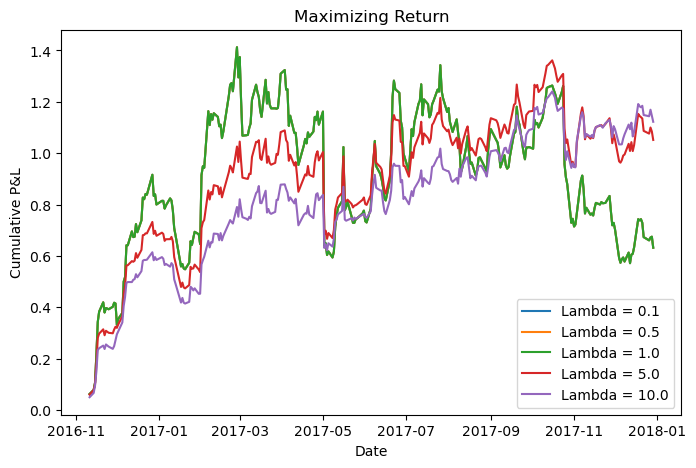

In [9]:
# Plot the P&L curves for each lambda
plt.figure(figsize=(8, 5), dpi=100)
for lambda_value, cumulative_pnl in maximize_results.items():
    plt.plot(cumulative_pnl, label=f'Lambda = {lambda_value}')
    
plt.title('Maximizing Return')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

**Discussion:** The Information Ratio (IR) scores how well we balance returns with risk. A higher score means we are getting good returns without too much risk. In the above example, as lambda increases, the IR also goes up. Thus, focusing more on minimizing risk improves the balance between how much money we make and how low-risk the returns are.

#### 2) Solve to minimize risk

In [10]:
# Define lambda values for the experiment
lambdas = [0.1, 0.5, 1.0, 5.0, 10.0]
minimize_results = {}

for lambda_value in lambdas:
    # Get optimized portfolio weights
    optimal_weights = minimize_risk(train_returns, lambda_value)
    
    # Calculate daily returns of the portfolio in the testing period
    portfolio_daily_returns = test_returns @ optimal_weights
    
    # Calculate cumulative P&L (Profit & Loss)
    cumulative_pnl = (1 + portfolio_daily_returns).cumprod() - 1
    minimize_results[lambda_value] = cumulative_pnl

    # Information Ratio calculation
    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std()
    information_ratio = avg_return / std_dev_return

    print(f"Lambda {lambda_value} - Information Ratio: {information_ratio:.3f}")

Lambda 0.1 - Information Ratio: 0.110
Lambda 0.5 - Information Ratio: 0.212
Lambda 1.0 - Information Ratio: 0.110
Lambda 5.0 - Information Ratio: 0.212
Lambda 10.0 - Information Ratio: 0.110


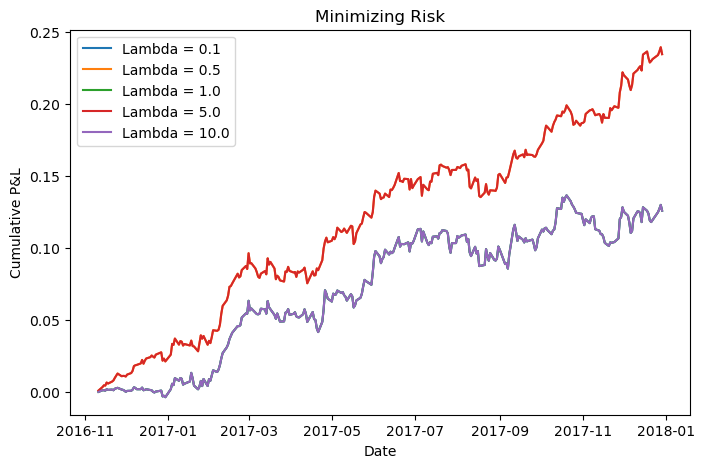

In [11]:
# Plot the P&L curves for each lambda
plt.figure(figsize=(8, 5), dpi=100)
for lambda_value, cumulative_pnl in minimize_results.items():
    plt.plot(cumulative_pnl, label=f'Lambda = {lambda_value}')
    
plt.title('Minimizing Risk')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

**Discussion:** We see that the IR does not change over the lambda values. Minimizing the risk resulted in a higher IR than maximizing the return. This is expected since we reduced the risk through optimization.

## Mean-Variance Portfolio Optimization with Leverage

Now, we will modify Problem 1 to take into account the leverage. Hence, we will no longer have the long-only constraint.

In [12]:
def maximize_return_with_leverage(returns, lambda_value, leverage):
    n = returns.shape[1]
    
    # Calculate the mean returns and covariance matrix
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values

    # Define the optimization variables
    weights = cp.Variable(n)
    
    # Portfolio return and risk
    portfolio_return = mean_returns.T @ weights
    portfolio_risk = cp.quad_form(weights, cov_matrix)

    # Objective function: maximize return - lambda * risk
    objective = cp.Maximize(portfolio_return - lambda_value * portfolio_risk)

    # Constraints: sum of absolute weights = leverage and no long-only constraint
    constraints = [cp.norm(weights, 1) <= leverage]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Get optimized weights
    return weights.value

In [13]:
# Assume best_lambda is the best-performing lambda from Problem 1
best_lambda = 10.0

leverages = [1, 2, 4, 8, 10, 20]
results_with_leverage = {}

for leverage in leverages:
    # Get optimized portfolio weights with leverage
    optimal_weights = maximize_return_with_leverage(train_returns, best_lambda, leverage)
    
    # Calculate daily returns of the portfolio in the testing period
    portfolio_daily_returns = test_returns @ optimal_weights
    
    # Calculate cumulative P&L (Profit & Loss)
    cumulative_pnl = (1 + portfolio_daily_returns).cumprod() - 1
    results_with_leverage[leverage] = cumulative_pnl

    # Information Ratio calculation
    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std()
    information_ratio = avg_return / std_dev_return

    print(f"Leverage {leverage} - Information Ratio: {information_ratio:.3f}")

Leverage 1 - Information Ratio: 0.113
Leverage 2 - Information Ratio: 0.105
Leverage 4 - Information Ratio: 0.114
Leverage 8 - Information Ratio: 0.122
Leverage 10 - Information Ratio: 0.124
Leverage 20 - Information Ratio: 0.133


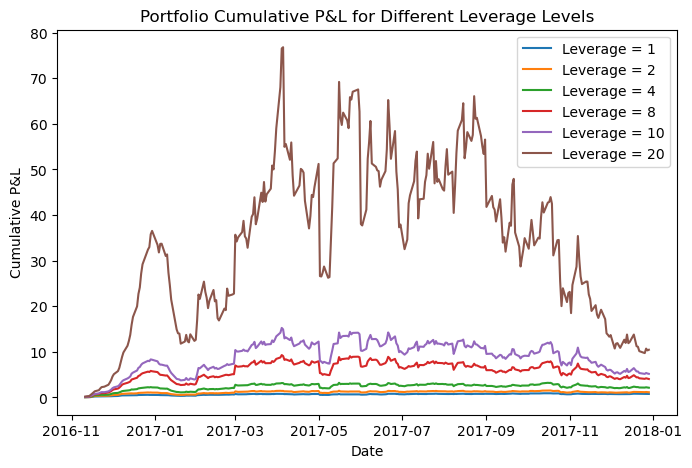

In [14]:
# Plot the P&L curves for each leverage
plt.figure(figsize=(8, 5), dpi=100)
for leverage, cumulative_pnl in results_with_leverage.items():
    plt.plot(cumulative_pnl, label=f'Leverage = {leverage}')
    
plt.title('Portfolio Cumulative P&L for Different Leverage Levels')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

**Discussion:** When we used more leverage, our portfolio took on more risk, but the reward also increased in a way that made the risk worthwhile. Here, the results show that with leverage 20, we can achieve a higher risk-adjusted return compared to lower leverage levels with the highest IR of 0.133. Even though leverage might be beneficial for maximizing returns, much higher leverage values contains huge variations and they could be risky if market conditions change.

## Risk Parity Portfolio Optimization

- We will now implement Risk-Parity Portfolio Optimization (equal risk contribution) on S&P 500 index constituent stocks between 2015-2017.
- We assume that stocks can only be long, and all portfolio should be allocated to stocks (We cannot hold cash).

In [15]:
def max_return_with_risk_constraint(returns, max_risk=0.05):
    # Number of assets
    n = returns.shape[1]
    # Covariance matrix of asset returns
    cov_matrix = returns.cov().values
    # Expected returns of each asset
    expected_returns = returns.mean().values

    # Define the variable for asset weights
    weights = cp.Variable(n)

    # Objective function: Maximize expected portfolio return
    objective = cp.Maximize(expected_returns @ weights)

    # Constraints
    constraints = [
        cp.sum(weights) == 1, # Fully invested portfolio
        weights >= 0, # Long-only constraint
    ]

    # Define and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Check if the problem was solved successfully
    if problem.status not in ["infeasible", "unbounded"]:
        return weights.value
    else:
        raise ValueError("The optimization problem is infeasible or unbounded.")

# Run the return-maximizing optimization with a risk constraint
optimal_weights = max_return_with_risk_constraint(train_returns)

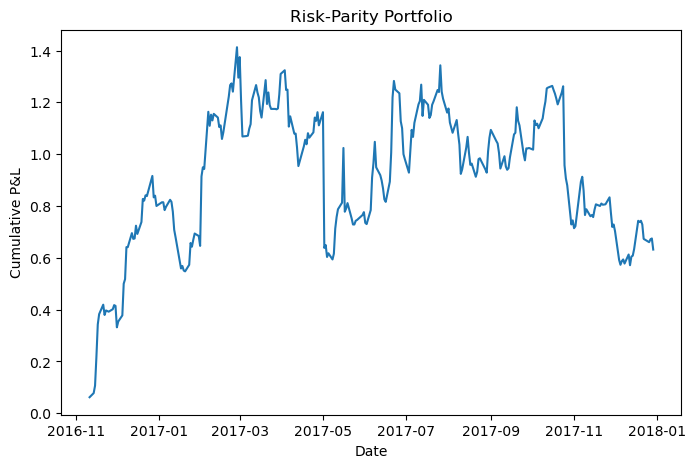

In [16]:
# Calculate portfolio daily returns in the testing period
portfolio_daily_returns = test_returns @ optimal_weights

# Calculate cumulative P&L
cumulative_pnl = (1 + portfolio_daily_returns).cumprod() - 1

# Plot P&L curve
plt.figure(figsize=(8, 5))
plt.plot(cumulative_pnl)
plt.xlabel("Date")
plt.ylabel("Cumulative P&L")
plt.title("Risk-Parity Portfolio")
plt.show()

In [17]:
# Information Ratio
avg_return = portfolio_daily_returns.mean()
std_dev_return = portfolio_daily_returns.std()
information_ratio = avg_return / std_dev_return
print(f"Information Ratio: {information_ratio:.3f}")

Information Ratio: 0.065


In [18]:
# Define the portfolio results as a list of dictionaries
portfolio_results = [
    {
        "Portfolio Name": "Mean-Variance (Maximize Return)",
        "Objective": "Maximize Return",
        "Lambda": 10,
        "Leverage": "-",
        "Information Ratio": 0.138
    },
    {
        "Portfolio Name": "Mean-Variance (Minimize Risk)",
        "Objective": "Minimize Risk",
        "Lambda": "0.1 and 0.5",
        "Leverage": "-",
        "Information Ratio": 0.212
    },
    {
        "Portfolio Name": "Mean-Variance with Leverage",
        "Objective": "-",
        "Lambda": "-",
        "Leverage": 20,
        "Information Ratio": 0.133
    },
    {
        "Portfolio Name": "Risk Parity Portfolio",
        "Objective": "-",
        "Lambda": "-",
        "Leverage": "-",
        "Information Ratio": 0.065
    }
]

# Create a df from the list of dictionaries
portfolio_df = pd.DataFrame(portfolio_results)
portfolio_df

,Portfolio Name,Objective,Lambda,Leverage,Information Ratio
0,Mean-Variance (Maximize Return),Maximize Return,10,-,0.138
1,Mean-Variance (Minimize Risk),Minimize Risk,0.1 and 0.5,-,0.212
2,Mean-Variance with Leverage,-,-,20,0.133
3,Risk Parity Portfolio,-,-,-,0.065


**Discussion:** The portfolio optimization results show varied performance across different strategies. The Mean-Variance Portfolio (maximize return, λ=10) achieves an Information Ratio (IR) of 0.138, balancing return and risk with a higher risk tolerance. The Mean-Variance Portfolio (minimize risk, λ=0.1 and 0.5) stands out with the highest IR of 0.212, indicating the best risk-adjusted return by focusing on reducing risk. The Mean-Variance Portfolio with Leverage (leverage=20) has a similar IR of 0.133, suggesting that leveraging does not significantly improve risk-adjusted returns compared to maximizing returns without leverage. Lastly, the Risk Parity Portfolio performs the weakest, with an IR of 0.065, emphasizing stability but lacking a favorable return-to-risk ratio. Overall, the strategy minimizing risk (λ=0.1 and 0.5) delivers the most efficient risk-adjusted return, while the risk parity approach offers the least optimal performance.

## Rebalanced Portfolio Optimization

Rebalancing is periodically adjusting the assets' weights to maintain a target allocation, ensuring that the portfolio aligns with the investor's risk tolerance and goals.

In [19]:
# Load S&P 500 tickers from file
with open(os.path.join(data_directory, 'sp500tickers.txt'), 'r') as f:
    tickers = f.read().splitlines()

data = yf.download(tickers, start="2015-01-01", end="2017-12-31")['Adj Close']
returns = data.pct_change().dropna()

# Split data into training and testing periods
train_returns = returns['2015-01-01':'2016-12-31']
test_returns = returns['2016-01-01':'2017-12-31']

# Calculate expected returns and covariance matrix from the training period
expected_returns = train_returns.mean()
cov_matrix = train_returns.cov()

print(f"Shape of expected returns: {expected_returns.shape}")
print(f"Shape of covariance matrix: {cov_matrix.shape}")

[*********************100%***********************]  480 of 480 completed


Shape of expected returns: (480,)
Shape of covariance matrix: (480, 480)


In [20]:
# Function to calculate portfolio performance (return and risk)
def portfolio_performance(weights, expected_returns, cov_matrix):
    port_return = np.sum(weights * expected_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Function to minimize (objective function for Mean-Variance Optimization)
def objective_function(weights, lambda_, expected_returns, cov_matrix):
    port_return, port_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    return -port_return + lambda_ * port_volatility

# Function to perform Mean-Variance Optimization
def mean_variance_optimization(lambda_, expected_returns, cov_matrix):
    n = len(expected_returns)
    initial_weights = np.ones(n) / n  # Equal starting weights
    bounds = [(0, 1) for _ in range(n)]  # Long-only constraint
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
    # fun: The value of the objective function at the optimal solutio
    
    result = minimize(
        objective_function, 
        initial_weights, 
        args=(lambda_, expected_returns, cov_matrix),
        bounds=bounds, 
        constraints=constraints,
    )
    
    return result.x # Return the optimized values of the decision variables

# Perform optimization for different lambda values
lambda_values = [0.1, 1.0, 5.0, 10.0]
optimized_weights = {lambda_: mean_variance_optimization(lambda_, expected_returns, cov_matrix) for lambda_ in lambda_values}

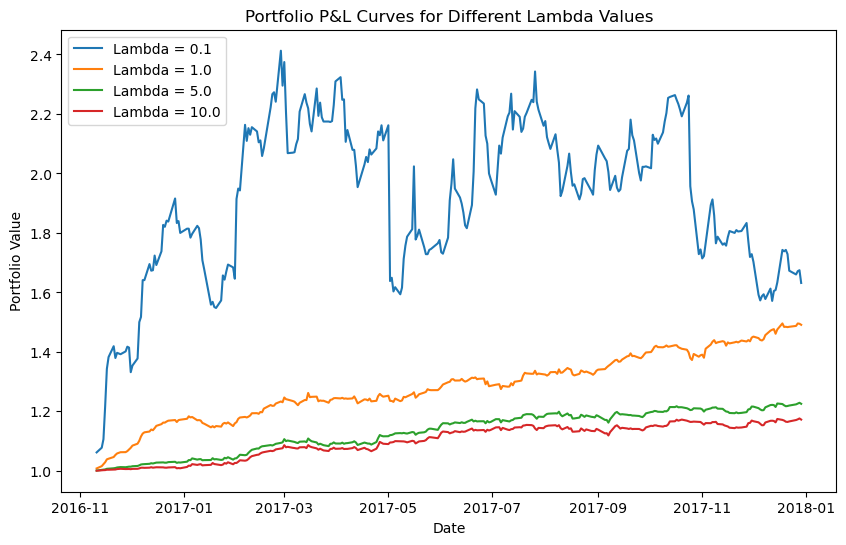

In [21]:
# Simulate portfolio performance during the test period
def simulate_portfolio(weights, returns, initial_capital=1.0):
    capital = initial_capital
    portfolio_values = []
    
    for date, daily_returns in returns.iterrows():
        daily_return = np.dot(weights, daily_returns)
        capital *= (1 + daily_return)
        portfolio_values.append(capital)
    
    return pd.Series(portfolio_values, index=returns.index)

# Plot P&L curves for different lambda values
plt.figure(figsize=(10, 6))
for lambda_, weights in optimized_weights.items():
    portfolio_values = simulate_portfolio(weights, test_returns)
    plt.plot(portfolio_values, label=f'Lambda = {lambda_}')

plt.title('Portfolio P&L Curves for Different Lambda Values')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [22]:
# Define the risk-free rate (annualized, e.g., 2%)
risk_free_rate = 0.02 / 252  # Convert to daily rate (assuming 252 trading days)

# Calculate and print the Information Ratios for each lambda
for lambda_, weights in optimized_weights.items():
    # Calculate portfolio returns
    portfolio_returns = pd.Series(np.dot(test_returns, weights), index=test_returns.index)
    
    # Calculate excess returns (portfolio return - risk-free rate)
    excess_returns = portfolio_returns - risk_free_rate
    
    # Calculate Information Ratio (mean and standard deviation of excess returns)
    ir = excess_returns.mean() / excess_returns.std()
    
    # Check for NaN or zero variance in the IR
    if np.isnan(ir) or np.isinf(ir):
        print(f"Information Ratio for Lambda = {lambda_}: Invalid (NaN or Inf)")
    else:
        print(f"Information Ratio for Lambda = {lambda_}: {ir:.4f}")

Information Ratio for Lambda = 0.1: 0.0630
Information Ratio for Lambda = 1.0: 0.2310
Information Ratio for Lambda = 5.0: 0.1649
Information Ratio for Lambda = 10.0: 0.1263


**Discussion:** The Information Ratio (IR) results indicate that lambda = 1.0 provides the best risk-adjusted return, with the highest IR, suggesting an optimal balance between risk and return. Lambda = 0.1 results in the lowest IR, likely due to excessive focus on return at the cost of higher volatility. Lambda = 5.0 offers a moderate risk-return trade-off but still underperforms compared to lambda = 1.0. Lambda = 10.0 shows lower risk-adjusted performance, indicating that prioritizing risk minimization too much can reduce excess returns. Thus, lambda = 1.0 is the most efficient way to maximize the information ratio in this case.

# END